# Cart endgame

## Import and load the original data

In [1]:
import sys
sys.path.insert(1, '../') 
from utils.loader import Loader
from utils.data_processor import Data_processor
from utils.evaluator import evaluator

import pandas as pd
from sklearn import tree
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.decomposition import PCA,TruncatedSVD
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import chi2
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import prince
import numpy as np

In [ ]:
data = Loader.load_by_fueltype("Eléctrico")
label_encoder = LabelEncoder()
data["price_categ"].value_counts()

### Describe some columns
A more detailed version of the dataset can be found in the DataDescription.ipynb

In [ ]:
data.select_dtypes(include=['category'])

In [ ]:
precios_electricos = data["price"]
plt.figure(figsize=(8, 6))
plt.boxplot(precios_electricos, notch=True, vert=True, patch_artist=True, showmeans=True)
plt.title('Boxplot de Precios')
plt.ylabel('Precio')
plt.grid(True)
plt.show()

The related outliers were checked manually throught the data source, and we could confirmed that they are not outliers

In [ ]:
Q1 = data['price'].quantile(0.25)
Q2 = data['price'].quantile(0.5)  # Esta es la mediana
Q3 = data['price'].quantile(0.75)
IQR = Q3 - Q1

upper_whisker = (Q3 + 1.5 * IQR)
print(upper_whisker)

data[data["fuelType"] == "Eléctrico"][data["price"]>upper_whisker][["price", "brand"]].sort_values(by='price', ascending=False)

# Electric cars

## Numerical variables selection Eléctrico
Here we will perform PCA and use correlation matrix to select the most correlated numerical variables

In [6]:
def fill_electric_numerical_columns(numerical_columns: pd.DataFrame) -> pd.DataFrame:
    #fill the elemental columns that has a minor amount of missing data with the mode
    numerical_columns = Data_processor.fill_na_with_mode(numerical_columns, "dimensions.length")
    numerical_columns = Data_processor.fill_na_with_mode(numerical_columns, "dimensions.height")
    numerical_columns = Data_processor.fill_na_with_mode(numerical_columns, "electricFeatures.maximumBatteryKWH_kWh")
    numerical_columns = Data_processor.fill_na_with_mode(numerical_columns, "electricFeatures.onboardCharger_kW")
    numerical_columns = Data_processor.fill_na_with_mode(numerical_columns, "electricFeatures.range_KM")

    #fill the missing data witch regression, the parameters were based on the relation matrix 
    numerical_columns = Data_processor.impute_with_linear_regression(data=numerical_columns, x_columns=["dimensions.length", "dimensions.height"], y_column="dimensions.width")
    numerical_columns = Data_processor.impute_with_linear_regression(data=numerical_columns, x_columns=["dimensions.length", "dimensions.height", "dimensions.width"], y_column="trunkCapacityInLiters")
    numerical_columns = Data_processor.impute_with_linear_regression(data=numerical_columns, x_columns=["power_cv", "power_kw"], y_column="maxSpeed")
    numerical_columns = Data_processor.impute_with_linear_regression(data=numerical_columns, x_columns=["power_cv", "power_kw", "maxSpeed"], y_column="acceleration")
    numerical_columns = Data_processor.impute_with_linear_regression(data=numerical_columns, x_columns=["power_cv", "power_kw", "maxSpeed"], y_column="acceleration")
    numerical_columns = Data_processor.impute_with_linear_regression(data=numerical_columns, x_columns=["Llantas_Diametro_cm", "power_kw"], y_column="max_torque_nm")
    numerical_columns = Data_processor.impute_with_linear_regression(data=numerical_columns, x_columns=["electricFeatures.maximumBatteryKWH_kWh", "power_kw", "dimensions.length", "dimensions.height", "dimensions.width"], y_column="electricFeatures.combinedConsumption_kWh/")
    numerical_columns = Data_processor.impute_with_linear_regression(data=numerical_columns, x_columns=["electricFeatures.maximumBatteryKWH_kWh", "electricFeatures.combinedConsumption_kWh/", "power_kw"], y_column="electricFeatures.range_KM")
    numerical_columns.dropna(axis=1, inplace=True)
    return numerical_columns

def get_electric_numerical_columns (data: pd.DataFrame) -> pd.DataFrame:
    numerical_columns = data.select_dtypes(include=['number'])
    numerical_columns.drop(columns=[ "car_id", "electricFeatures.maxPower_CV"], inplace=True) # electricFeatures.maxPower_CV is = power_cv (Duplicated colums)

    #if all the values of the numerical columns is 0, we remove the column
    cols_to_drop = numerical_columns.columns[(numerical_columns == 0).all()]
    numerical_columns = numerical_columns.drop(cols_to_drop, axis=1)

    #Remove the column with all NAs
    max_nans = 6586
    thresh = numerical_columns.shape[0] - max_nans

    numerical_columns.dropna(axis=1, thresh=thresh+1, inplace=True)
    return fill_electric_numerical_columns(numerical_columns)

In [ ]:
numerical_columns = get_electric_numerical_columns(data)

In [ ]:
correlation_matrix = numerical_columns.corr()["price"]
print(correlation_matrix)

In [9]:
scaler = StandardScaler()
df_scaled  = scaler.fit_transform(numerical_columns)

pca = PCA(n_components=2)
principal_components = pca.fit_transform(df_scaled)
df_pca = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

In [ ]:
def biplot(score, coeff, labels=None):
    plt.figure(figsize=(10, 8))
    origin = [0, 0]  # Origen de las flechas

    # Dibujar las flechas
    for i in range(len(coeff)):
        plt.arrow(origin[0], origin[1], coeff[i,0], coeff[i,1], color='r', alpha=0.5, head_width=0.05, head_length=0.1)
        if labels is not None:
            plt.text(coeff[i,0]*1.15, coeff[i,1]*1.15, labels[i], color='blue', ha='center', va='center')

    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title("Biplot")
    plt.grid(True)
    plt.axhline(0, color='black',linewidth=0.5)
    plt.axvline(0, color='black',linewidth=0.5)
    plt.xlim(min(coeff[:,0])*1.2, max(coeff[:,0])*1.2)
    plt.ylim(min(coeff[:,1])*1.2, max(coeff[:,1])*1.2)
    plt.show()

# Llamada a la función biplot
biplot(principal_components, np.transpose(pca.components_[0:2, :]), labels=numerical_columns.columns)

## Test CART regression trees with only numerical variables

In [ ]:
X = numerical_columns.drop(columns="price")
y = numerical_columns["price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

tree_model = DecisionTreeRegressor(random_state=42)
tree_model.fit(X_train, y_train)

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Realizar predicciones sobre el conjunto de prueba
y_pred = tree_model.predict(X_test)

evaluator.eval_regression(y_pred, y_test)

## Electrico categorical variables
Here we will perform CA and Chi2 test to select the best categorical variables

In [13]:
def get_electric_categorical_columns(df: pd.DataFrame) -> pd.DataFrame:
    ret = df.select_dtypes(include=['category'])
    ret = ret.drop(columns=["environmentalLabel"]) #All of the cars of this dataframes are electrical which implies 0 emission
    ret = Data_processor.remove_redundand_columns(ret)
    ret = Data_processor.impute_categorical_mode(df=ret, X=["brand", "model"], Y="version")
    ret = Data_processor.impute_categorical_mode(df=ret, X=["brand", "model"], Y="jato_classification")
    ret = Data_processor.impute_categorical_mode(df=ret, X=["brand", "model", "traction"], Y="brakes")
    ret = Data_processor.impute_categorical_mode(df=ret, X=["brand", "model", "traction","brakes"], Y="front_suspension")
    ret = Data_processor.impute_categorical_mode(df=ret, X=["brand", "model", "traction","brakes"], Y="rear_suspension")
    return ret

In [14]:
categorical_columns = get_electric_categorical_columns(data)

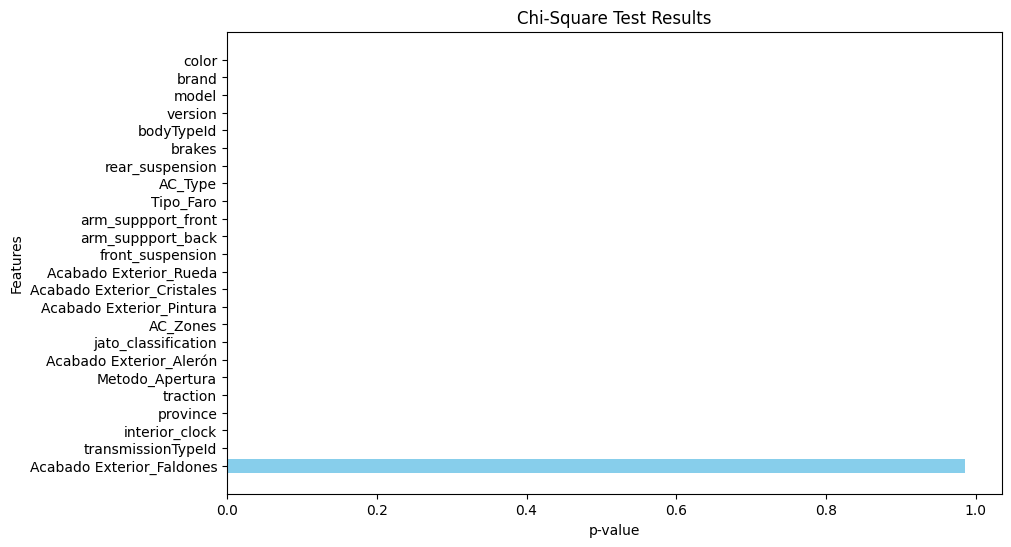

,Feature,Chi2 Stat,p-value
0,color,17355.917738,0.000000e+00
1,brand,1800.198086,0.000000e+00
2,model,15590.848906,0.000000e+00
3,version,19903.204434,0.000000e+00
4,bodyTypeId,6530.816750,0.000000e+00
9,brakes,1581.335781,0.000000e+00
11,rear_suspension,1848.387572,0.000000e+00
18,AC_Type,1486.737498,0.000000e+00
20,Tipo_Faro,1590.069687,0.000000e+00
22,arm_suppport_front,3759.181818,0.000000e+00


In [15]:
Data_processor.chi_square_test(categorical_columns=categorical_columns, column_y="price_categ")

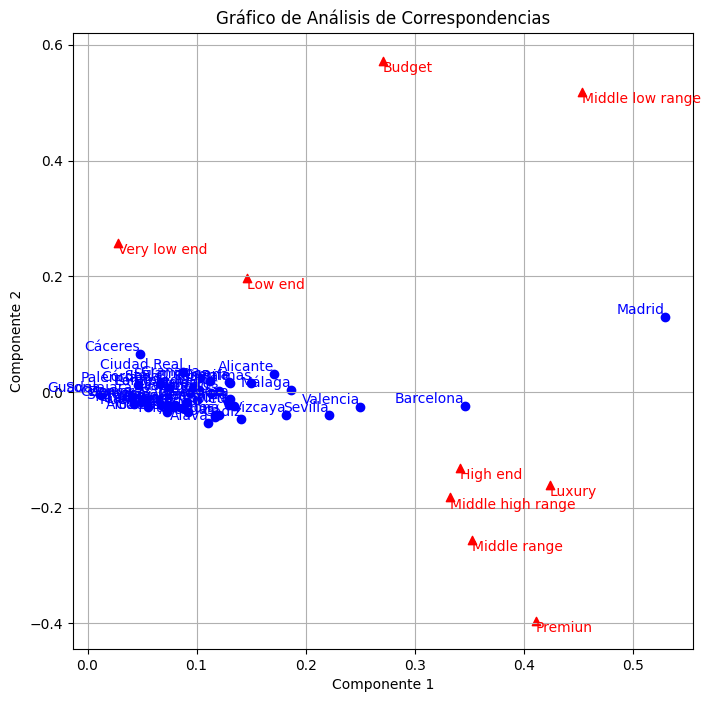

In [16]:
Data_processor.CA(categorical_columns=categorical_columns, col_x="province", col_y="price_categ")

In [17]:
categorical_columns["price_categ"].value_counts()

price_categ
Middle low range     1353
Luxury               1182
Premiun              1113
Middle range          820
High end              767
Middle high range     727
Budget                483
Low end               141
Very low end            5
Name: count, dtype: int64

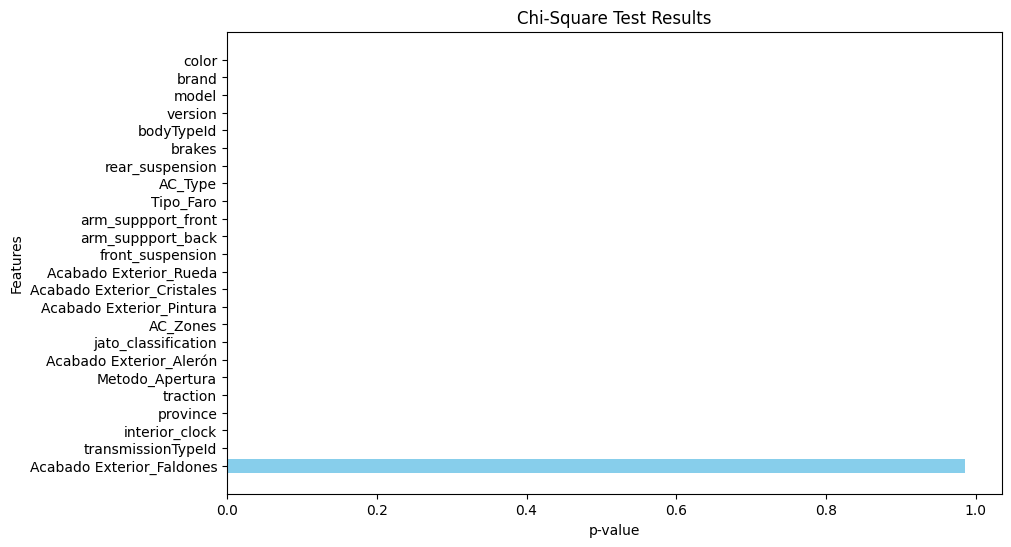

Index(['color', 'brand', 'model', 'version', 'bodyTypeId', 'brakes',
       'rear_suspension', 'AC_Type', 'Tipo_Faro', 'arm_suppport_front',
       'arm_suppport_back', 'price_categ'],
      dtype='object')

In [18]:
categorical_columns = Data_processor.chi_square_filter(categorical_columns, "price_categ", p_value_filter=0)
categorical_columns.columns

## Test CART tree classifier with only categorical values

In [19]:
columns = list(categorical_columns.columns)
columns.remove("price_categ")
for col in columns:
    categorical_columns[col] = label_encoder.fit_transform(categorical_columns[col])

# Preparar los datos
X = categorical_columns.drop(columns=["price_categ"])
Y = categorical_columns["price_categ"].apply(lambda x: Loader.encode_price_categ(x))

# Dividir los datos en entrenamiento y prueba
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42, stratify=Y)

# Crear el modelo de árbol de decisión
tree_model = DecisionTreeClassifier(random_state=42, criterion = "entropy")

# Entrenar el modelo
tree_model.fit(X_train, Y_train)

# Predecir las etiquetas del conjunto de prueba
Y_pred = tree_model.predict(X_test)

In [20]:
result = pd.DataFrame({"Real_Categorie": Y_test, "Prediction": Y_pred})
result["diff"] = np.abs(result["Real_Categorie"].astype(int) - result["Prediction"])
result["Real_Categorie"] = result["Real_Categorie"].apply(Loader.decode_price_categ)
result["Prediction"] = result["Prediction"].apply(Loader.decode_price_categ)
result

,Real_Categorie,Prediction,diff
4294,Luxury,Luxury,0
6000,Middle range,Middle range,0
5558,High end,High end,0
4938,Budget,Budget,0
3754,Luxury,Middle high range,3
...,...,...,...
1230,Luxury,High end,2
5552,High end,Premiun,1
1395,Premiun,Middle range,3
5599,Luxury,Luxury,0


In [21]:
# Calcular la precisión
evaluator.eval_classfication(y_pred=result["Prediction"].to_numpy(), y_true=result["Real_Categorie"].to_numpy(), binary_classification=False)

Accuracy: 0.609201213346815 Precision: 0.6119752867487853 Recall: 0.609201213346815 F1 Score: 0.609991738812089
Confusion Matrix:
 [[291   6   5   0  16  38  50   0   0]
 [  6  91   0  11  53   0  25  44   0]
 [  2   0  30   0   1   8   1   0   0]
 [  1  18   0 268   5   0   0  63   0]
 [ 22  29   3   1  94   0  50  19   0]
 [ 24   0  14   0   0 102   5   0   0]
 [ 63  15   1   1  42   0 121   3   0]
 [  1  59   1  45  12   1   7 208   0]
 [  0   0   1   0   0   1   0   0   0]]


/home/lingfeng/Desktop/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


We can verify that the prediction is not very accurate but we need to know how big is the error.

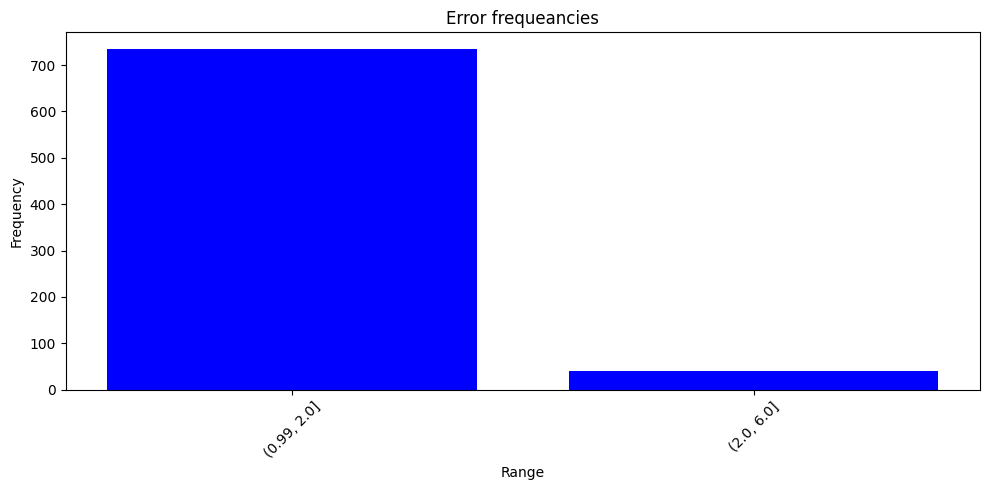

Errors: {'(0.99, 2.0]': 734, '(2.0, 6.0]': 39}
Error mean: 1.3130659767141009
Error rate: 39.0798786653185 %
Overall mean: 0.5131445904954499


In [22]:
evaluator.eval_ordinal_classification (result["diff"])

Even having errors, we can verify that the errors are not that big

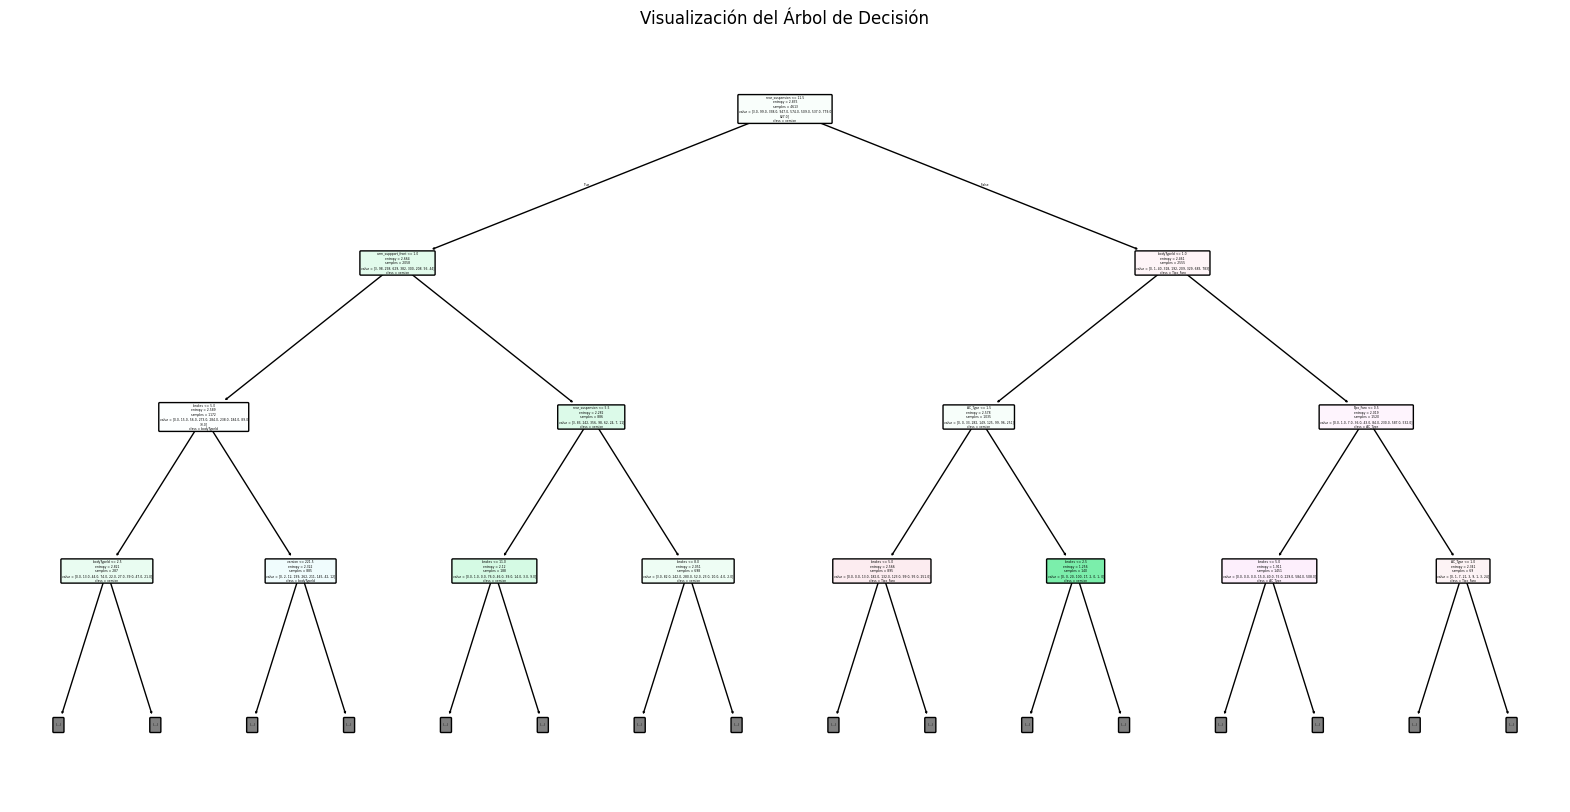

In [23]:
plt.figure(figsize=(20,10))

# Dibujar el árbol de decisión
plot_tree(tree_model, 
          filled=True, 
          rounded=True, 
          class_names=X_train.columns, 
          feature_names=X.columns, 
          max_depth=3)  # Puedes ajustar la profundidad para una mejor visualización o quitar este parámetro para mostrar todo el árbol
plt.title('Visualización del Árbol de Decisión')
plt.show()

## Electric cars price regression with all the columns